## Import des librairies

In [1]:
import twint
import nest_asyncio
import numpy as np
import pandas as pd
from unidecode import unidecode
import re,string
from collections import Counter
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
nest_asyncio.apply()

# 1.<span style="color:red"> EXTRACTION & COLLECTE DES TWEETS </span>

In [3]:
# Configuration 
#c = twint.Config()
#c.Search ="europeansuperleague OR superleague européene"  #Topic de recherche
#c.Lang = "fr" #langue des Tweets
#c.Store_csv = True #Type de storage
#c.Output = "data/ESL.CSV" #Adresse du storage
#c.Pandas= True #conversion vers df
#c.Since = "2021-04-18" #date de début
#twint.run.Search(c) 

In [4]:
df = pd.read_csv("data/ESL.csv")
df = df.loc[df['language'] == "fr"]
df = df.loc[:, ['date', 'time','tweet', 'likes_count','retweets_count']]
df = df.drop_duplicates(subset='tweet', keep="first") #Suppression des doublons

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2405 entries, 0 to 4246
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            2405 non-null   object
 1   time            2405 non-null   object
 2   tweet           2405 non-null   object
 3   likes_count     2405 non-null   int64 
 4   retweets_count  2405 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 112.7+ KB


In [6]:
df['date'].describe(datetime_is_numeric=True).to_frame()

,date
count,2405
unique,43
top,2021-04-19
freq,1039


In [7]:
df.isna().sum()

date              0
time              0
tweet             0
likes_count       0
retweets_count    0
dtype: int64

In [8]:
df.head(10)

,date,time,tweet,likes_count,retweets_count
0,2021-05-31,15:35:04,Super League : La Cour de Justice Européenne o...,0,0
1,2021-05-31,14:21:13,Super League: la Cour de justice de l’Union eu...,0,0
2,2021-05-31,13:17:06,Super League: la Cour de justice de l’Union eu...,4,3
3,2021-05-31,13:16:05,Super League: la Cour de justice de l’Union eu...,0,0
4,2021-05-31,13:15:07,Super League: la Cour de justice de l’Union eu...,0,0
5,2021-05-31,12:39:22,Super League: la Cour de justice de l'Union eu...,0,0
6,2021-05-31,12:32:50,Super League: la Cour de justice de l'Union eu...,0,0
7,2021-05-31,12:19:18,Le cas de la #SuperLeague sera discuté par la ...,6,0
8,2021-05-31,11:02:03,Le cas de la #SuperLeague sera discuté par la ...,100,20
9,2021-05-31,10:53:10,SUPERLEAGUE : L'UEFA et la FIFA portés devant ...,3,1


# 2. <span style="color:blue">  PREPROCESSING</span>

### 2.1 <span style="color:black">  ANALYSE DESCRIPTIVE</span>

In [9]:
pd.options.display.max_colwidth = 150

In [10]:
#Conversion de la colonne tweet en liste
twt_list=df['tweet'].tolist()
print(f"La liste est composée de {len(twt_list)} tweets")

La liste est composée de 2405 tweets


In [11]:
i = 2390

for twt in twt_list:
    if i <= len(twt_list):
        print(f"Le tweet {i} est de longueur : {len(twt)}")
    i+=1

Le tweet 2390 est de longueur : 175
Le tweet 2391 est de longueur : 147
Le tweet 2392 est de longueur : 149
Le tweet 2393 est de longueur : 124
Le tweet 2394 est de longueur : 149
Le tweet 2395 est de longueur : 99
Le tweet 2396 est de longueur : 124
Le tweet 2397 est de longueur : 266
Le tweet 2398 est de longueur : 266
Le tweet 2399 est de longueur : 122
Le tweet 2400 est de longueur : 159
Le tweet 2401 est de longueur : 280
Le tweet 2402 est de longueur : 167
Le tweet 2403 est de longueur : 188
Le tweet 2404 est de longueur : 54
Le tweet 2405 est de longueur : 101


In [12]:
i = 2398

for twt in twt_list:
    liste_mots = twt.split() # Permet de séparer les mots d'une chaines de caractère en fonction d'un séparateur 
                             # par défault l'espace.
    if i <= len(twt_list):    
        print(f"Le tweet {i} contient {len(liste_mots)} mots")
        print(f"La liste de mots du tweet {i} : {liste_mots} \n")
        i+=1

Le tweet 2398 contient 22 mots
La liste de mots du tweet 2398 : ['Super', 'League', ':', 'La', 'Cour', 'de', 'Justice', 'Européenne', 'ouvre', 'une', 'procédure', 'contre', 'la', 'FIFA', 'et', "l'UEFA", 'https://t.co/jEOQLqly0f', '#Sport', '#Cour_de_Justice_Européenne', '#Fifa', '#Super_League', '#UEFA'] 

Le tweet 2399 contient 21 mots
La liste de mots du tweet 2399 : ['Super', 'League:', 'la', 'Cour', 'de', 'justice', 'de', 'l’Union', 'européenne', 'ouvre', 'une', 'procédure', 'contre', 'l’UEFA', 'et', 'la', 'Fifa', ':', 'https://t.co/HBP8RtepZA', 'via', '@sudpresseonline'] 

Le tweet 2400 contient 19 mots
La liste de mots du tweet 2400 : ['Super', 'League:', 'la', 'Cour', 'de', 'justice', 'de', 'l’Union', 'européenne', 'ouvre', 'une', 'procédure', 'contre', 'l’UEFA', 'et', 'la', 'Fifa', 'https://t.co/juSL1t8nq5', 'https://t.co/SAtNY0i3qA'] 

Le tweet 2401 contient 18 mots
La liste de mots du tweet 2401 : ['Super', 'League:', 'la', 'Cour', 'de', 'justice', 'de', 'l’Union', 'européenn

In [13]:
#Les 10 tweets ayant sucités le plus de réactions
df.sort_values(['likes_count','retweets_count'],ascending = (False, False)).head(10)

,date,time,tweet,likes_count,retweets_count
1147,2021-04-19,13:22:13,"Des banderoles ont été affichées par les supporters des Reds devant Anfield. ""Honte sur vous"" ""RIP Liverpool, 1892-2021"" ""Les fans de Liverpool...",8799,1882
4047,2021-04-18,16:27:56,L’UEFA remercie les clubs français et les clubs allemands qui ont refusé de donner leur accord à la création de la Superleague Européenne.,8269,1053
3786,2021-04-18,20:09:19,"🔴 Sir Alex Ferguson dénonce le projet fermé d'une Superleague européenne : ""Parler d'une Super League, c'est s'éloigner de 70 ans du football euro...",8071,1316
3965,2021-04-18,17:05:35,"Emmanuel Macron ""salue la position des clubs français de refuser de participer à un projet de Superleague européenne de football menaçant le princ...",7154,726
1165,2021-04-19,13:05:25,"Toni Kroos, en novembre dernier : « Une SuperLeague européenne ? Nous ne sommes que des marionnettes de la FIFA et de l’UEFA. S’il y avait un syn...",4999,1115
975,2021-04-19,17:23:13,Le gouvernement espagnol ne soutient pas la création d'une Super League européenne. (Diario AS) https://t.co/8xvXDmMMBY,4379,469
916,2021-04-19,18:28:46,🔴 Le comité exécutif de l’UEFA discutera ce vendredi d’une possible exclusion des clubs impliqués dans la Super League Européenne. Les clubs conc...,2903,469
4212,2021-04-18,15:02:27,"🔴 Des clubs anglais, espagnols et italiens devraient officialiser dans les prochaines heures la création de la Superleague Européenne. Dans cette...",2770,376
1227,2021-04-19,11:57:03,"Arsène Wenger : ""La Super League, c'est une mauvaise idée. Le foot doit rester uni et basé sur le mérite sportif. Il doit également respecter l'hi...",2752,609
991,2021-04-19,17:00:15,"🔴 L’UEFA songerait à expulser dès maintenant les équipes impliquées dans la Super League Européenne de ses compétitions. En #UCL, il ne resterait...",2485,558


### 2.2 <span style="color:black">  NETTOYAGE & TRANSFORMATION DE LA LISTE DES TWEETS</span>

In [14]:
stopWords = ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 
             'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 
             'aucun', 'aucune', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'auraient', 'aurait', 'auront', 'aussi', 
             'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 
             'avant', 'avec', 'avoir', 'avons', 'ayant', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'boum', 
             'bravo', 'brrr', "c'", 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 
             'celui', 'celui-ci', 'celui-là', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 'certes', 'ces', 
             'cet', 'cette', 'ceux', 'ceux-ci', 'ceux-là', 'chacun', 'chacune', 'chaque', 'cher', 'chers', 'chez', 'chiche', 'chut', 
             'chère', 'chères', 'ci', 'cinq', 'cinquantaine', 'cinquante', 'cinquantième', 'cinquième', 'clac', 'clic', 'combien', 
             'comme', 'comment', 'comparable', 'comparables', 'compris', 'concernant', 'contre', 'couic', 'crac', 'c’', "d'", 'da', 
             'dans', 'de', 'debout', 'dedans', 'dehors', 'deja', 'delà', 'depuis', 'dernier', 'derniere', 'derriere', 'derrière', 
             'des', 'desormais', 'desquelles', 'desquels', 'dessous', 'dessus', 'deux', 'deuxième', 'deuxièmement', 'devant', 'devers', 
             'devra', 'different', 'differentes', 'differents', 'différent', 'différente', 'différentes', 'différents', 'dire', 
             'directe', 'directement', 'dit', 'dite', 'dits', 'divers', 'diverse', 'diverses', 'dix', 'dix-huit', 'dix-neuf', 
             'dix-sept', 'dixième', 'doit', 'doivent', 'donc', 'dont', 'douze', 'douzième', 'dring', 'du', 'duquel', 'durant', 'dès', 
             'désormais', 'd’', 'effet', 'egale', 'egalement', 'egales', 'eh', 'elle', 'elle-même', 'elles', 'elles-mêmes', 'en', 
             'encore', 'enfin', 'entre', 'envers', 'environ', 'es', 'est', 'et', 'etaient', 'etais', 'etait', 'etant', 'etc', 'etre', 
             'eu', 'euh', 'eux', 'eux-mêmes', 'exactement', 'excepté', 'extenso', 'exterieur', 'fais', 'faisaient', 'faisant', 'fait', 
             'façon', 'feront', 'fi', 'flac', 'floc', 'font', 'gens', 'ha', 'hein', 'hem', 'hep', 'hi', 'ho', 'holà', 'hop', 'hormis', 
             'hors', 'hou', 'houp', 'hue', 'hui', 'huit', 'huitième', 'hum', 'hurrah', 'hé', 'hélas', 'i', 'il', 'ils', 'importe', 
             "j'", 'je', 'jusqu', 'jusque', 'juste', 'j’', "l'", 'la', 'laisser', 'laquelle', 'las', 'le', 'lequel', 'les', 
             'lesquelles', 'lesquels', 'leur', 'leurs', 'longtemps', 'lors', 'lorsque', 'lui', 'lui-meme', 'lui-même', 'là', 'lès', 'l’', 
             "m'", 'ma', 'maint', 'maintenant', 'mais', 'malgre', 'malgré', 'maximale', 'me', 'meme', 'memes', 'merci', 'mes', 'mien', 'mienne', 
             'miennes', 'miens', 'mille', 'mince', 'minimale', 'moi', 'moi-meme', 'moi-même', 'moindres', 'moins', 'mon', 
             'moyennant', 'même', 'mêmes', 'm’', "n'", 'na', 'naturel', 'naturelle', 'naturelles', 'ne', 'neanmoins', 'necessaire', 
             'necessairement', 'neuf', 'neuvième', 'ni', 'nombreuses', 'nombreux', 'non', 'nos', 'notamment', 'notre', 'nous', 'nous-mêmes', 
             'nouveau', 'nul', 'néanmoins', 'nôtre', 'nôtres', 'n’', 'o', 'oh', 'ohé', 'ollé', 'olé', 'on', 'ont', 'onze', 'onzième', 'ore', 
             'ou', 'ouf', 'ouias', 'oust', 'ouste', 'outre', 'ouvert', 'ouverte', 'ouverts', 'où', 'paf', 'pan', 'par', 'parce', 'parfois', 
             'parle', 'parlent', 'parler', 'parmi', 'parseme', 'partant', 'particulier', 'particulière', 'particulièrement', 'pas', 'passé', 
             'pendant', 'pense', 'permet', 'personne', 'peu', 'peut', 'peuvent', 'peux', 'pff', 'pfft', 'pfut', 'pif', 'pire', 'plein', 'plouf', 
             'plus', 'plusieurs', 'plutôt', 'possessif', 'possessifs', 'possible', 'possibles', 'pouah', 'pour', 'pourquoi', 'pourrais', 'pourrait', 
             'pouvait', 'prealable', 'precisement', 'premier', 'première', 'premièrement', 'pres', 'probable', 'probante', 'procedant', 'proche', 
             'près', 'psitt', 'pu', 'puis', 'puisque', 'pur', 'pure', "qu'", 'quand', 'quant', 'quant-à-soi', 'quanta', 'quarante', 'quatorze', 
             'quatre', 'quatre-vingt', 'quatrième', 'quatrièmement', 'que', 'quel', 'quelconque', 'quelle', 'quelles', "quelqu'un", 'quelque', 
             'quelques', 'quels', 'qui', 'quiconque', 'quinze', 'quoi', 'quoique', 'qu’', 'rare', 'rarement', 'rares', 'relative', 'relativement', 
             'remarquable', 'rend', 'rendre', 'restant', 'reste', 'restent', 'restrictif', 'retour', 'revoici', 'revoilà', 'rien', "s'", 'sa', 
             'sacrebleu', 'sait', 'sans', 'sapristi', 'sauf', 'se', 'sein', 'seize', 'selon', 'semblable', 'semblaient', 'semble', 'semblent', 
             'sent', 'sept', 'septième', 'sera', 'seraient', 'serait', 'seront', 'ses', 'seul', 'seule', 'seulement', 'si', 'sien', 'sienne', 
             'siennes', 'siens', 'sinon', 'six', 'sixième', 'soi', 'soi-même', 'soit', 'soixante', 'son', 'sont', 'sous', 'souvent', 'specifique', 
             'specifiques', 'speculatif', 'stop', 'strictement', 'subtiles', 'suffisant', 'suffisante', 'suffit', 'suis', 'suit', 'suivant', 
             'suivante', 'suivantes', 'suivants', 'suivre', 'superpose', 'sur', 'surtout', 's’', "t'", 'ta', 'tac', 'tant', 'tardive', 'te', 
             'tel', 'telle', 'tellement', 'telles', 'tels', 'tenant', 'tend', 'tenir', 'tente', 'tes', 'tic', 'tien', 'tienne', 'tiennes', 
             'tiens', 'toc', 'toi', 'toi-même', 'ton', 'touchant', 'toujours', 'tous', 'tout', 'toute', 'toutefois', 'toutes', 'treize', 'trente', 
             'tres', 'trois', 'troisième', 'troisièmement', 'trop', 'très', 'tsoin', 'tsouin', 'tu', 'té', 't’', 'un', 'une', 'unes', 
             'uniformement', 'unique', 'uniques', 'uns', 'va', 'vais', 'vas', 'vers', 'via', 'vif', 'vifs', 'vingt', 'vivat', 'vive', 'vives', 
             'vlan', 'voici', 'voilà', 'vont', 'vos', 'votre', 'vous', 'vous-mêmes', 'vu', 'vé', 'vôtre', 'vôtres', 'zut', 'à', 'â', 'ça', 'ès', 
             'étaient', 'étais', 'était', 'étant', 'été', 'être', 'ô','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 
             'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'qu', "»", "«",'quelqu']

In [15]:
emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symboles & pictographes
                       u"\U0001F680-\U0001F6FF"  # transport & cartographie
                       u"\U0001F1E0-\U0001F1FF"  # Drapeaux (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)  

def emoji(string):
    return emoji_pattern.sub(r'', string)

In [16]:
def df_cleaner(pandasSeries, stopWords):
    
    print("#### Nettoyage en cours ####") 
    
    # confirmation que chaque article est bien de type str
    pandasSeries = pandasSeries.apply(lambda x : str(x))
    
    # Passage en minuscule
    print("... Passage en minuscule") 
    pandasSeries = pandasSeries.apply(lambda x : x.lower())
    
    #Suppression de la ponctuation
    print("... Suppression de la ponctuation")
    pandasSeries = pandasSeries.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
    
    # Suppression des urls
    print("... Suppression des urls") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"http\S+", '', x)) 
    
    # Suppression des pseudos
    print("... Suppression des pseudos") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"@\S+", '', x))
    
    # Suppression des hashtags
    print("... Suppression des hashtags") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"#\S+", '', x))
   
    # Suppression des emojis
    print("... Suppression des emojis") 
    pandasSeries = pandasSeries.apply(emoji)
    
    # Suppression des stop words
    print("... Suppression des stop words") 
    pandasSeries = pandasSeries.apply(lambda x:' '.join([word for word in x.split() if word not in stopWords]))
    
    print("#### Nettoyage OK! ####")

    return pandasSeries

In [17]:
%%time 
df['tweet_clean'] = df_cleaner(df['tweet'], stopWords)

df[['tweet', 'tweet_clean']].head(20)

#### Nettoyage en cours ####
... Passage en minuscule
... Suppression de la ponctuation
... Suppression des urls
... Suppression des pseudos
... Suppression des hashtags
... Suppression des emojis
... Suppression des stop words
#### Nettoyage OK! ####
Wall time: 577 ms


,tweet,tweet_clean
0,Super League : La Cour de Justice Européenne ouvre une procédure contre la FIFA et l'UEFA https://t.co/jEOQLqly0f #Sport #Cour_de_Justice_Europée...,super league cour justice européenne ouvre procédure fifa luefa sport courdejusticeeuropéenne fifa superleague uefa
1,Super League: la Cour de justice de l’Union européenne ouvre une procédure contre l’UEFA et la Fifa : https://t.co/HBP8RtepZA via @sudpresseonline,super league cour justice l’union européenne ouvre procédure l’uefa fifa sudpresseonline
2,Super League: la Cour de justice de l’Union européenne ouvre une procédure contre l’UEFA et la Fifa https://t.co/juSL1t8nq5 https://t.co/SAtNY0i3qA,super league cour justice l’union européenne ouvre procédure l’uefa fifa
3,Super League: la Cour de justice de l’Union européenne ouvre une procédure contre l’UEFA et la Fifa https://t.co/7mJRFcdmXG,super league cour justice l’union européenne ouvre procédure l’uefa fifa
4,Super League: la Cour de justice de l’Union européenne ouvre une procédure contre l’UEFA et la Fifa https://t.co/9kpuFwqMNQ https://t.co/SdXY7YQd2X,super league cour justice l’union européenne ouvre procédure l’uefa fifa
5,Super League: la Cour de justice de l'Union européenne ouvre une procédure contre l'UEFA et la Fifa,super league cour justice lunion européenne ouvre procédure luefa fifa
6,Super League: la Cour de justice de l'Union européenne ouvre une procédure contre l'UEFA et la Fifa https://t.co/BctzHccEwO,super league cour justice lunion européenne ouvre procédure luefa fifa
7,Le cas de la #SuperLeague sera discuté par la Cour Européenne de Justice. L'objectif est de clarifier si l'exclusivité de l'organisation d'événem...,cas superleague discuté cour européenne justice lobjectif clarifier lexclusivité lorganisation dévénements sportifs luefa fifa viole principe libr...
8,Le cas de la #SuperLeague sera discuté par la Cour Européenne de Justice. L'objectif est de clarifier si l'exclusivité de l'organisation d'événem...,cas superleague discuté cour européenne justice lobjectif clarifier lexclusivité lorganisation dévénements sportifs luefa fifa viole principe libr...
9,SUPERLEAGUE : L'UEFA et la FIFA portés devant la Cour Européenne par les trois clubs fondateurs : https://t.co/SB3NlGIixK,superleague luefa fifa portés cour européenne clubs fondateurs


# 3. <span style="color:GREEN">  DATA VIZ </span>

### 3.1 <span style="color:black">  Nombre de mots </span>

In [18]:
df1 = (df['tweet_clean'].str.split(expand=True).stack().value_counts().rename_axis('mots').reset_index(name='Occurrences')).set_index('mots')
df1.head(20)

,Occurrences
mots,
européenne,2363
league,1617
super,1583
superleague,1075
clubs,741
football,444
projet,338
compétition,264
ligue,240


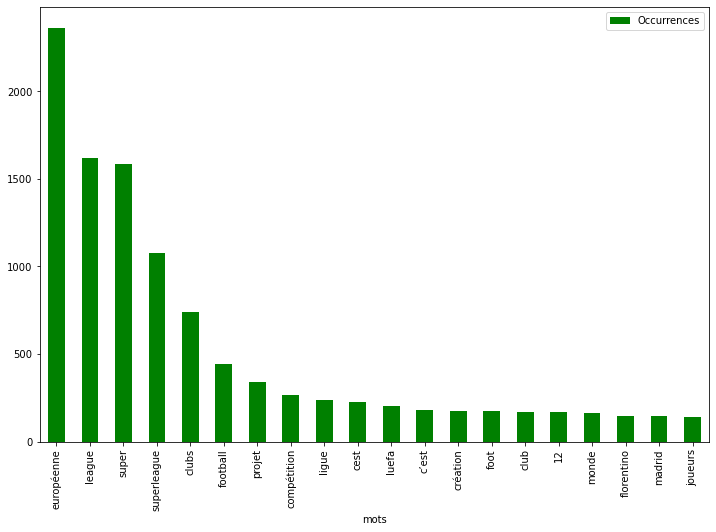

In [19]:
df1.head(20).plot(kind = "bar", figsize=(12, 8), color = "Green");

### 3.2 <span style="color:black"> Bigrammes </span>

In [20]:
corpus = df['tweet_clean'].str.split()

In [21]:
# bigrammes dans un document
print(f"Notre document n° 77: {corpus[77]} \n")


print(f"La liste des bigrammes présents dans le document n°77 : {list(nltk.bigrams(corpus[77]))}")

Notre document n° 77: ['clubs', 'football', 'voulu', 'créer', 'nouvelle', 'compétition', 'européenne', 'superligue', 'sanctionnés', 'clubs', 'refusent', 'dabandonner', 'projet', 'risquent', 'sanctions', 'lourdes', 'uefa', 'superleague'] 

La liste des bigrammes présents dans le document n°77 : [('clubs', 'football'), ('football', 'voulu'), ('voulu', 'créer'), ('créer', 'nouvelle'), ('nouvelle', 'compétition'), ('compétition', 'européenne'), ('européenne', 'superligue'), ('superligue', 'sanctionnés'), ('sanctionnés', 'clubs'), ('clubs', 'refusent'), ('refusent', 'dabandonner'), ('dabandonner', 'projet'), ('projet', 'risquent'), ('risquent', 'sanctions'), ('sanctions', 'lourdes'), ('lourdes', 'uefa'), ('uefa', 'superleague')]


### 3.3 <span style="color:black"> Nuages de mots </span>

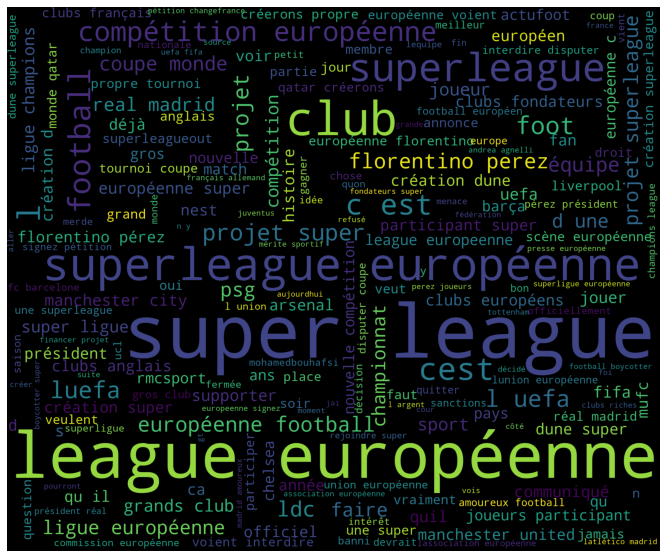

In [22]:
wordcloud = WordCloud(width = 1200,height = 1000,scale = 2, background_color='black',collocations=True).generate(' '.join(df["tweet_clean"]))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# 4. <span style="color:Orange">  Classification non supervisée </span>

[![Unsupervised.png](https://i.postimg.cc/TYBv1nJ3/Unsupervised.png)](https://postimg.cc/svPN0QLk)

**Clustering**  : c'est une méthode de regroupement des objets en groupes de telle sorte que ceux qui présentent le plus de similitudes restent dans un groupe et présentent moins ou pas de similitudes avec les objets d'un autre groupe. L'analyse de cluster trouve les points communs entre les objets de données et les catégorise selon la présence et l'absence de ces points communs.

**Association**: Une règle d'association est une méthode d'apprentissage non supervisée qui est utilisée pour trouver les relations entre les variables dans une base de données. Il détermine l'ensemble des éléments qui se produisent ensemble dans l'ensemble de données. La règle d'association peut rendre une stratégie marketing plus efficace. Comme les personnes qui achètent un article X (supposons un pain) ont également tendance à acheter un article Y (beurre/confiture). Un exemple typique de règle d'association est l'analyse du panier de marché.

Parmi les algorithmes les plus utilisés dans l'apprentissage non supervisé :

- K-means clustering  
- KNN (k-nearest neighbors)
- Hierarchal clustering
- Topic Modelling (LDA / NMF)
- Anomaly detection
- Neural Networks
- Principle Component Analysis
- Independent Component Analysis
- Apriori algorithm
- Singular value decomposition

### 4.1 <span style="color:black">  K-means Clustering</span>

####  4.1.1 <span style="color:black">  TF-IDF</span>

Le ratio TF-IDF (Term-Frequency - Inverse Document Frequency) permet de pondérer la fréquence des tokens (mots dans notre corpus) dans un document par son importance relative dans les autres documents.

Ce score tient donc compte de la composition de notre corpus.

In [23]:
#Vectorisation des trigram et avec un minimum d'apparitions de 2 fois
vectorizer = TfidfVectorizer(ngram_range=range(1,3), min_df=2,stop_words=stopWords)
X = vectorizer.fit_transform(df['tweet_clean'])

print(X.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
print(vectorizer.get_feature_names())

['00', '00 real', '000', '10', '10 ans', '10 juventus', '10 équipes', '100', '100 super', '10eme', '11', '11 clubs', '11 fulham', '12', '12 club', '12 clubs', '12 grands', '12 puissants', '12 salopards', '12 équipes', '13', '14', '14 clubs', '15', '15 ans', '15 clubs', '15 faveur', '15 fondateurs', '15 millions', '150', '150 victoire', '16', '16 clubs', '16 permanents', '17', '18', '18 clubs', '18 finale', '18922021', '18922021 fans', '19', '19 avril', '1993', '1998', '19h', '1er', '1ere', '1ere place', '1ère', '20', '20 avril', '20 clubs', '20 équipes', '2000', '20042021', '2009', '2009 florentino', '2016', '2018', '2020', '20202021', '202021', '2021', '2021 réussi', '2021 super', '2022', '2022 qatar', '2024', '22', '22h30', '23', '23 ans', '24', '24 heures', '25', '2e', '2ème', '2ème division', '30', '30 tweets', '34', '350', '350 gagnant', '350 millions', '350m', '350m ny', '3e', '3eme', '40', '40 clubs', '400m', '400m participer', '425', '425 millions', '48', '48h', '4ème', '50', '

In [25]:
mots = ' '.join(df['tweet_clean']) # Concaténation des documents renvoi une chaine de caractères

liste_mots = re.findall(r"\w+", mots) # Création de la liste contenant tous les mots de notre corpus
print(f"Ci-dessous, la liste de mots présents dans le corpus : \n{liste_mots}\n")

vocab = set(liste_mots)
print(f"Le vocabulaire est de taille {len(vocab)}")
print(f"Ci-dessous, le vocabulaire (mots uniques) : \n{vocab}\n")


Ci-dessous, la liste de mots présents dans le corpus : 
['super', 'league', 'cour', 'justice', 'européenne', 'ouvre', 'procédure', 'fifa', 'luefa', 'sport', 'courdejusticeeuropéenne', 'fifa', 'superleague', 'uefa', 'super', 'league', 'cour', 'justice', 'l', 'union', 'européenne', 'ouvre', 'procédure', 'l', 'uefa', 'fifa', 'sudpresseonline', 'super', 'league', 'cour', 'justice', 'l', 'union', 'européenne', 'ouvre', 'procédure', 'l', 'uefa', 'fifa', 'super', 'league', 'cour', 'justice', 'l', 'union', 'européenne', 'ouvre', 'procédure', 'l', 'uefa', 'fifa', 'super', 'league', 'cour', 'justice', 'l', 'union', 'européenne', 'ouvre', 'procédure', 'l', 'uefa', 'fifa', 'super', 'league', 'cour', 'justice', 'lunion', 'européenne', 'ouvre', 'procédure', 'luefa', 'fifa', 'super', 'league', 'cour', 'justice', 'lunion', 'européenne', 'ouvre', 'procédure', 'luefa', 'fifa', 'cas', 'superleague', 'discuté', 'cour', 'européenne', 'justice', 'lobjectif', 'clarifier', 'lexclusivité', 'lorganisation', 'dé

In [26]:
# Initialisation du dictionnaire
freq = defaultdict(int)

# Compte l'ocurrence de chaque mot du corpus
for mot in liste_mots:
    freq[mot] += 1
    
print(freq)

defaultdict(<class 'int'>, {'super': 1620, 'league': 1650, 'cour': 23, 'justice': 29, 'européenne': 2370, 'ouvre': 9, 'procédure': 8, 'fifa': 123, 'luefa': 204, 'sport': 65, 'courdejusticeeuropéenne': 1, 'superleague': 1077, 'uefa': 198, 'l': 473, 'union': 29, 'sudpresseonline': 2, 'lunion': 26, 'cas': 25, 'discuté': 2, 'lobjectif': 3, 'clarifier': 3, 'lexclusivité': 2, 'lorganisation': 3, 'dévénements': 2, 'sportifs': 3, 'viole': 3, 'principe': 17, 'libre': 8, 'concurrence': 22, 'dimarzio': 2, 'portés': 2, 'clubs': 741, 'fondateurs': 58, 'annonce': 63, 'porté': 14, 'plainte': 2, 'violation': 1, 'lois': 3, 'florentino': 147, 'perez': 126, 'travaille': 3, 'également': 21, 'coupe': 126, 'monde': 166, 'lieu': 16, 'ans': 42, '2': 33, 'comprendra': 3, 'grands': 80, 'entier': 5, 'président': 122, 'infantino': 11, 'impliqué': 4, 'projet': 338, 'vozpopuli': 1, 'qualifications': 1, 'relégations': 4, 'mécanisme': 2, 'solidarité': 19, 'foot': 173, 'chelsea': 66, 'thomas': 1, 'tuchel': 3, 'remport

####  4.1.2 <span style="color:black">  Choix du nombre de clusters `true_k` avec la méthode "elbow"</span>

Le choix du true_k se fera graphiquement en prenant l'abcisse du coude correspondant à une faible pente du graph.

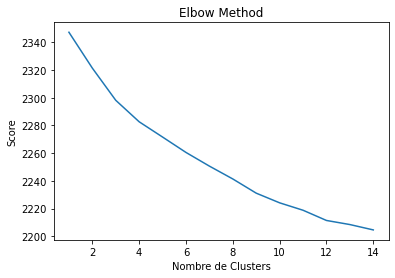

In [27]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss)
plt.title('Elbow Method')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score')
plt.show()

####  4.1.3 <span style="color:black">  Application de l'algorithme K-means</span>

In [28]:
true_k = 9
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
model.fit(X)

print("Top termes par cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")

Top termes par cluster:
Cluster 0:
 victoire
 150
 victoire luefa
 350 gagnant
 150 victoire
 gagnant 500m
 luefa 824
 européenne 350
 500m
 824
Cluster 1:
 league
 super league
 super
 league européenne
 européenne
 football
 projet
 projet super
 cest
 foot
Cluster 2:
 superleague
 superleague européenne
 européenne
 football
 projet superleague
 projet
 cest
 compétition
 clubs
 uefa
Cluster 3:
 coupe monde
 coupe
 monde
 propre
 2022
 monde 2022
 créerons propre
 créerons
 tournoi coupe
 2022 qatar
Cluster 4:
 clubs
 12
 12 clubs
 européenne
 league
 super league
 super
 compétition
 superleague
 grands
Cluster 5:
 manchester
 manchester city
 city
 officiellement
 retrait
 league européenne
 league
 super league
 confirme
 super
Cluster 6:
 ligue
 ligue européenne
 super ligue
 ligue champions
 champions
 superleague
 super
 européenne
 fermée
 projet
Cluster 7:
 real
 madrid
 real madrid
 juventus
 milan
 barcelone
 super league
 league
 super
 manchester
Cluster 8:
 amoureux foo

####  4.1.4 <span style="color:black">  Test de prédiction du cluster</span>

In [29]:
print("\n")
print("Prediction")
X = vectorizer.transform(["est ce que Liverpool a rejoint la super league européene?"])
predicted = model.predict(X)
print(predicted)



Prediction
[1]


### 4.2 <span style="color:black">  Topic Modelling (LatentDirichletAllocation)</span>

####  4.2.1 <span style="color:black">  Vectorisation & Transformation </span>

In [30]:
#Filtre appliqué sur les mots qui apparaissent dans moins de 10% des tweets 
vectorizer = CountVectorizer(min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

In [31]:
tf = vectorizer.fit_transform(df['tweet_clean']).toarray()

In [32]:
tf_feature_names = vectorizer.get_feature_names()

####  4.2.2 <span style="color:black">  Modélisation </span>

In [33]:
#Choix de nombre de topics arbitraire
number_of_topics = 6

model2 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model2.fit(tf)

LatentDirichletAllocation(n_components=6, random_state=0)

In [34]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [35]:
no_top_words = 10
display_topics(model2, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,européenne,499.5,européenne,210.9,league,1246.1,européenne,453.1,monde,152.4,européenne,177.7
1,superleague,480.2,league,184.4,super,1226.7,superleague,443.4,coupe,126.2,league,114.0
2,l,365.3,super,177.1,européenne,979.4,clubs,253.4,joueurs,99.5,superleague,75.0
3,d,229.4,psg,118.2,clubs,309.1,cest,133.8,participant,52.2,€,72.2
4,’est,203.0,jouer,92.2,football,168.0,manchester,101.2,européenne,47.5,football,64.9
5,football,180.0,perez,91.1,projet,127.9,arsenal,92.1,super,46.0,super,56.4
6,c,176.8,superleague,74.3,club,84.3,madrid,85.9,league,44.8,projet,55.2
7,ligue,149.2,président,74.0,création,83.7,city,75.2,propre,43.2,»,49.1
8,’uefa,113.0,florentino,69.4,l,81.2,club,67.1,qatar,38.2,actufoot,49.1
9,clubs,112.8,compétition,62.9,luefa,77.3,united,66.2,2022,37.2,joueurs,42.8


Sans trop de surprises, les termes ayant le plus de poids (occurences) dans les tweets sont :
- super league européenne
- UEFA / FIFA
- 12 clubs fondateurs de l'ESL
- Florentino Perez le président du Réal Madrid par celui l'annonce est venue
- PSG / Real / Manchester U/ Manchester City/ Arsenal / Milan : qui sont les clubs protagonistes ou antagonistes du projet

### 4.3 <span style="color:black">  Topic Modelling (Non-Negative Matrix Factorization)</span>

In [36]:
D = TfidfVectorizer(min_df=25, stop_words=stopWords)
# Fit and transform
F = D.fit_transform(df.tweet_clean)

In [37]:
model3 = NMF(n_components=6, random_state=5)
model3.fit(F)
nmf_features = model3.transform(F)

In [38]:
components_df = pd.DataFrame(model3.components_, columns=D.get_feature_names())
components_df

,12,2022,accord,actufoot,agnelli,allemands,amoureux,anglais,annonce,annoncé,...,union,united,veulent,veut,vient,voient,voir,vraiment,équipe,équipes
0,0.000000,0.000000,0.000000,0.084219,0.000000,0.000000,0.000000,0.011550,0.030305,0.000000,...,0.036125,0.031310,0.013884,0.034523,0.027640,0.000000,0.048246,0.008838,0.016929,0.053454
1,0.000000,0.000000,0.003988,0.034108,0.015231,0.000000,0.000000,0.000000,0.010790,0.000000,...,0.031005,0.000000,0.002835,0.041529,0.020781,0.000000,0.048416,0.039110,0.041405,0.026053
2,0.834301,0.000000,0.100940,0.046886,0.033845,0.161251,0.000000,0.378653,0.042629,0.082042,...,0.000000,0.138853,0.097447,0.050541,0.011521,0.000000,0.109545,0.043574,0.016120,0.136524
3,0.000000,0.000000,0.007148,0.000000,0.000000,0.000000,0.101203,0.000000,0.099778,0.069560,...,0.050202,0.000336,0.000000,0.003495,0.000000,0.000000,0.016384,0.017813,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.054417,0.000000,0.000000,0.000000,0.128271,0.056752,...,0.027462,0.023190,0.000000,0.011794,0.011194,0.000000,0.001440,0.022280,0.024763,0.000000
5,0.000000,0.361347,0.000000,0.000000,0.137980,0.000000,0.179611,0.000000,0.005552,0.000000,...,0.000000,0.011135,0.013299,0.015735,0.014822,0.311769,0.002115,0.000000,0.019676,0.080268


In [39]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'les mots les plus récurrents du {topic+1} :')
    print(tmp.nlargest(10))
    print('\n')

les mots les plus récurrents du 1 :
league        2.988878
super         2.923026
européenne    1.911375
foot          0.205441
création      0.170838
cest          0.159071
mufc          0.129121
club          0.124310
psg           0.115250
nouvelle      0.105467
Name: 0, dtype: float64


les mots les plus récurrents du 2 :
superleague    2.947997
européenne     1.480137
foot           0.226231
création       0.177944
cest           0.175439
ligue          0.173649
compétition    0.173405
psg            0.163556
uefa           0.152989
superligue     0.128310
Name: 1, dtype: float64


les mots les plus récurrents du 3 :
clubs          2.468771
12             0.834301
compétition    0.623463
luefa          0.548826
uefa           0.533654
création       0.382463
anglais        0.378653
cest           0.347486
grands         0.335432
fondateurs     0.313437
Name: 2, dtype: float64


les mots les plus récurrents du 4 :
football     2.997351
sport        0.216640
européen     0.179951
ue